In [10]:
%matplotlib inline
import netCDF4 as nc
import numpy as np
import datetime as DT
import sys, pickle
sys.path.append('/home/spike/repos')
from testbedutils import sblib as sb
from getdatatestbed import getDataFRF
from testbedutils import waveLib as wl
sys.path.append('/home/spike/cmtb')
from plotting.nonoperationalPlots import plot_scatterAndQQ
import researchLib as RL
from matplotlib import pyplot as plt 

##################################################################
start = DT.datetime(2015, 10, 1)
end = DT.datetime(2016, 10, 1)
IGcutoff = 1/25  # frequency seconds for infragravity cut off
HFcutoff = 1/2.  # high frequency cutoff

In [85]:
def halfPlanePolarPlot(spectra, frequencies, directions, lims=[-18, 162], **kwargs):
    """ creates single polar plot for spectra 
    
    Args:
        spectra (array): 2D array only
        frequencies (array): 1 d array of corresponding frequencies to spectra
        directions(array): directions associated with spectra
        lims (list): default is half plane for Duck (incident energy only), will NOT truncate spectra
            set to None if looking to plot whole 360 polar plot
    
    Keyword Args:
        'contour_levels'(list): a list of contour levels to color
        'figsize' (tup): a tuple of figure size eg. (12, 10)
        'fname' (str): file path save name
    Returns:
        Axis object 
            
    """  
    # begin by checking inputs
    assert np.array(spectra).ndim == 2, 'spectra needs to be 2 dimensional'
    assert np.array(spectra).shape[0] == np.array(frequencies).shape[0], 'spectra should be shaped by freq then direction'
    assert np.array(spectra).shape[1] == np.array(directions).shape[0], 'spectra should be shaped by freq then direction'
    # pre-processing spectra
    Edarray = np.asarray(spectra, dtype=object)                  # make spectra an array (if not already )
    Ednew = np.append(spectra, spectra[:,0:1], axis=1)           # add extra directional band to get it to wrap 
    Dmean_rad = np.deg2rad(np.append(directions, directions[0])) # convert input directions to radian
    ## set Color-scale
    if 'contour_levels' in kwargs:                               # manually set contours
        contour_levels = kwargs['contour_levels']
    else:                                                        # automatically set contours 
        Edmax = float(np.max(spectra))                           # take max for colorbars
        contourNumber = 50                                       # set default number of contour levels 
        minlevel = Edmax/contourNumber                           # calculate min level 
        maxlevel = Edmax                                         # calculate max level
        step = (maxlevel - minlevel)/contourNumber               # associated step 
        contour_levels = np.arange(minlevel, maxlevel, step)     # create list/array of contour levels for plot
    if 'figsize' in kwargs:
        figSize = kwargs['figsize']
    else: 
        figSize=(11,11)
    ########################################################################
    fig = plt.figure(figsize=figSize)                                   # create figure 
    thetas = Dmean_rad[:] # in radian NOT DEGREES 

    ax = plt.subplot(111, polar=True)                                   # create polar axis object 
    ax.set_theta_direction(-1)                                          # set to counter clock-wise plot  
    ax.set_theta_zero_location("N")                                     # set zero as up 
    colorax = ax.contourf(thetas, frequencies, Ednew, contour_levels)   # make plot

    ## Set titles and colorbar
    plt.suptitle('Polar Spectrum ', fontsize=22, y=0.95, x=0.45)
    cbar = fig.colorbar(colorax)
    cbar.set_label('Energy Density ($m^2/Hz/deg$)', rotation=270, fontsize=16)
    cbar.ax.get_yaxis().labelpad = 30

    #     degrange = range(0,360,30)
    #     lines, labels = plt.thetagrids(degrange, labels=None, frac = 1.07)
    if lims is not None:  
        ax.set_thetalim(np.deg2rad(lims))
    if 'fname' in kwargs:
        plt.savefig(kwargs['fname']); plt.close()
        
    return ax

# Get Observations  and model data

In [62]:
gauge = 'awac-11m'
modlabel = '8m-array'
obslabel = gauge

go = getDataFRF.getObs(start, end)
gm = getDataFRF.getDataTestBed(start, end)
obs = go.getWaveSpec(gauge, removeBadDataFlag=3)
HPspecs, HPdirs = wl.HPchop_spec(obs['dWED'], obs['wavedirbin'], angadj=72)
mod = go.getWaveSpec('8m-array', removeBadDataFlag=3) #gm.getWaveSpecModel('HP', '8m-array', model='STWAVE')


# Now Show problem then isolate test case

In [64]:
#first time match 
matchedTime, idxobs, idxmod = sb.timeMatch(obs_time=obs['time'], obs_data=None, model_time=mod['time'], model_data=None)
mod_matched = sb.reduceDict(mod, idxmod)
obs_matched = sb.reduceDict(obs, idxobs)
# calculate stats  for Full plane 
mod_bulkStat_FP = wl.waveStat(mod_matched['dWED'], mod_matched['wavefreqbin'], mod_matched['wavedirbin'])
obs_bulkStat_FP = wl.waveStat(obs_matched['dWED'], obs_matched['wavefreqbin'], obs_matched['wavedirbin'])
# now Half plane 
mod_bulkStat_HP = RL.replaceWaveDictHalfPlaneSpectralStats(mod_matched, freqLims=(IGcutoff, HFcutoff))
obs_bulkStat_HP = RL.replaceWaveDictHalfPlaneSpectralStats(obs_matched, freqLims=(IGcutoff, HFcutoff))

In half plane, the awac-11m moves energy more shore normal than with the 8m-array


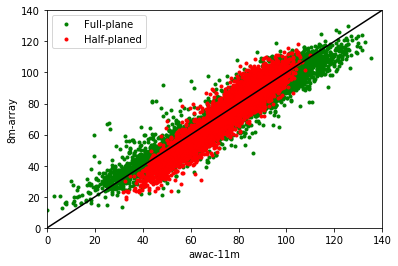

In [150]:
plt.figure()
plt.plot(obs_bulkStat_FP['Dm'], mod_bulkStat_FP['Dm'], 'g.', label='Full-plane')
plt.plot(obs_bulkStat_HP['Dm'], mod_bulkStat_HP['Dm'], 'r.', label='Half-planed')
plt.plot([0,180], [0, 180], 'k-')
plt.xlabel(obslabel)
plt.ylabel(modlabel)
plt.xlim([0,140])
plt.ylim([0, 140])
plt.legend()


In half plane, the awac-11m moves energy more shore normal than with the 8m-array

In [67]:
# create residuals between the HP and FP results and find the 90% largest residual
dirResiual_acoustic = obs_bulkStat_FP['Dm'] - obs_bulkStat_HP['Dm'] 

### Now plot the direction residual against wave height

Text(0.5,1,'histogram of residuals')

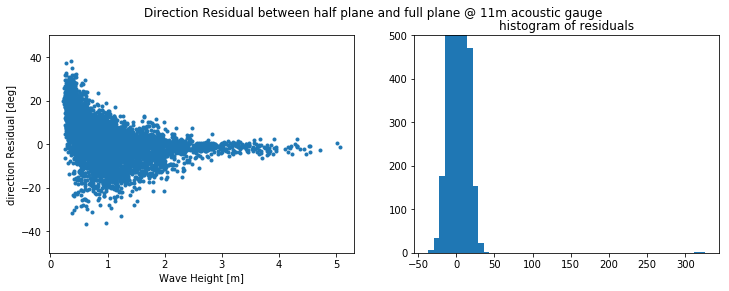

In [148]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(obs_bulkStat_FP['Hm0'], dirResiual_acoustic,'.')
plt.xlabel('Wave Height [m]')
plt.ylabel('direction Residual [deg]')
plt.suptitle('Direction Residual between half plane and full plane @ 11m acoustic gauge')
plt.ylim([-50, 50])
plt.subplot(122)
_ = plt.hist(dirResiual_acoustic, bins=50)
plt.ylim([0,500])
plt.title('histogram of residuals')

There's a clear problem during smaller waves between half-plane and full-planed spectra

In [140]:
# begin isolation of specific spectra
thresh = 28  # look for values bigger than this 
idxHighResidual = np.argwhere(dirResiual_acoustic > thresh).squeeze()
obs_matched_HP['time'][idxHighResidual]
idxOfInterest = idxHighResidual[6] # pick random index of interest from list 
# listInterest = [2, 4, 5, 6, 12, 18, 34]

# Begin looking at spectra
specifically those with < 0.05 m Hm0 differences @ full-plane between 8m and 11m 
that have a Dm residual > 28 between Half plane and Full plane (@11m)
Above __Black line__ is ocean propagating
__white line__ is shore normal

2016-02-29 10:00:00
awac-11m FP H_s: 0.26 [m] D_m 115.91 [deg] ........ 8m-array FP H_s: 0.25 [m] D_m: 113.56 [deg]
awac-11m HP H_s: 0.20 [m] D_m 86.50 [deg] ........ 8m-array HP H_s: 0.23 [m] D_m: 104.20 [deg]
HP diff     H_s: 0.06 [m] D_m 29.41 [deg] ........             H_s: 0.03 [m] D_m: 9.36 [deg]


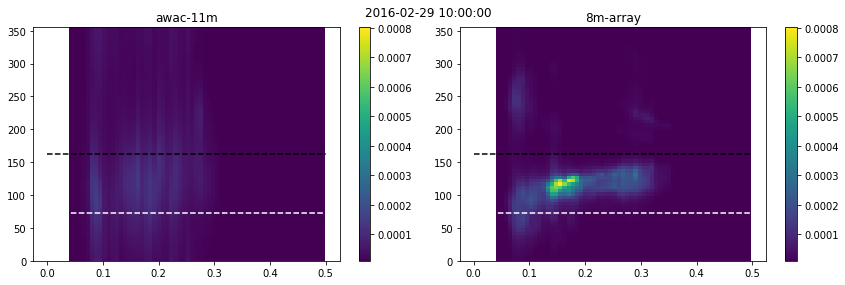

2016-03-24 09:00:00
awac-11m FP H_s: 0.33 [m] D_m 121.28 [deg] ........ 8m-array FP H_s: 0.29 [m] D_m: 108.16 [deg]
awac-11m HP H_s: 0.26 [m] D_m 90.46 [deg] ........ 8m-array HP H_s: 0.27 [m] D_m: 103.56 [deg]
HP diff     H_s: 0.07 [m] D_m 30.82 [deg] ........             H_s: 0.02 [m] D_m: 4.60 [deg]


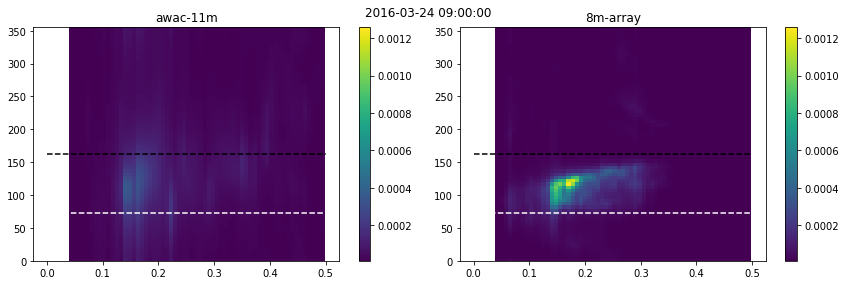

2016-07-26 11:00:00
awac-11m FP H_s: 0.27 [m] D_m 117.44 [deg] ........ 8m-array FP H_s: 0.22 [m] D_m: 106.88 [deg]
awac-11m HP H_s: 0.21 [m] D_m 85.66 [deg] ........ 8m-array HP H_s: 0.19 [m] D_m: 98.29 [deg]
HP diff     H_s: 0.06 [m] D_m 31.79 [deg] ........             H_s: 0.02 [m] D_m: 8.59 [deg]


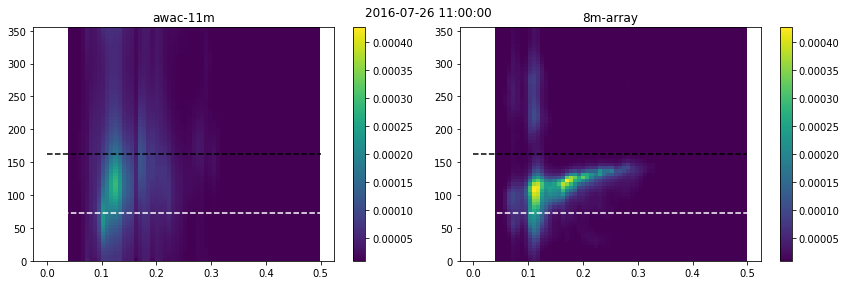

2016-07-28 13:00:00
awac-11m FP H_s: 0.25 [m] D_m 118.41 [deg] ........ 8m-array FP H_s: 0.22 [m] D_m: 98.38 [deg]
awac-11m HP H_s: 0.19 [m] D_m 86.76 [deg] ........ 8m-array HP H_s: 0.19 [m] D_m: 91.06 [deg]
HP diff     H_s: 0.06 [m] D_m 31.66 [deg] ........             H_s: 0.03 [m] D_m: 7.32 [deg]


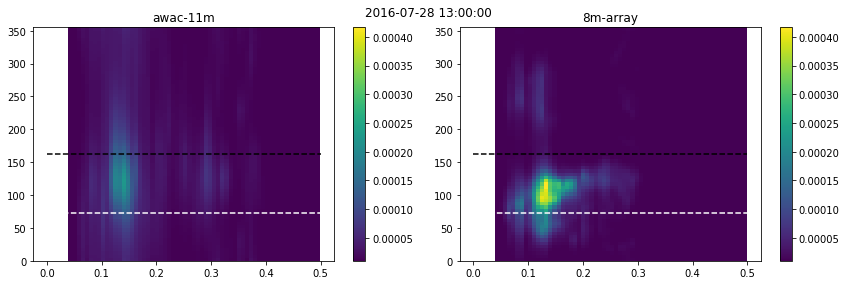

2016-07-29 13:00:00
awac-11m FP H_s: 0.28 [m] D_m 118.67 [deg] ........ 8m-array FP H_s: 0.23 [m] D_m: 108.65 [deg]
awac-11m HP H_s: 0.21 [m] D_m 85.81 [deg] ........ 8m-array HP H_s: 0.21 [m] D_m: 98.93 [deg]
HP diff     H_s: 0.07 [m] D_m 32.86 [deg] ........             H_s: 0.03 [m] D_m: 9.72 [deg]


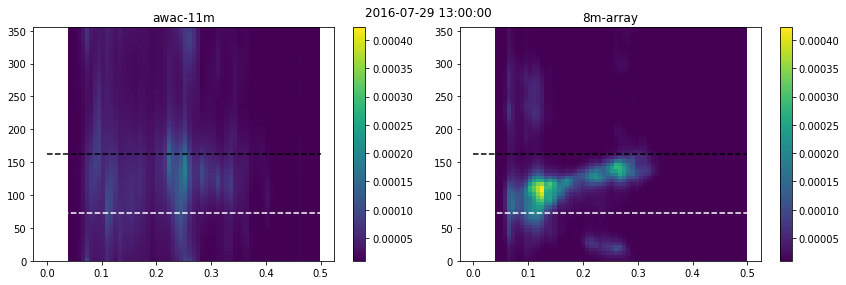

2016-08-01 13:00:00
awac-11m FP H_s: 0.31 [m] D_m 120.03 [deg] ........ 8m-array FP H_s: 0.28 [m] D_m: 110.41 [deg]
awac-11m HP H_s: 0.25 [m] D_m 91.04 [deg] ........ 8m-array HP H_s: 0.25 [m] D_m: 100.58 [deg]
HP diff     H_s: 0.06 [m] D_m 28.98 [deg] ........             H_s: 0.03 [m] D_m: 9.83 [deg]


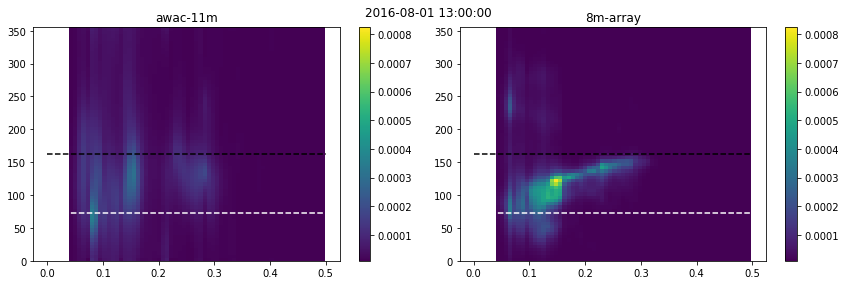

2016-08-02 02:00:00
awac-11m FP H_s: 0.32 [m] D_m 121.46 [deg] ........ 8m-array FP H_s: 0.29 [m] D_m: 110.02 [deg]
awac-11m HP H_s: 0.25 [m] D_m 90.84 [deg] ........ 8m-array HP H_s: 0.26 [m] D_m: 100.27 [deg]
HP diff     H_s: 0.07 [m] D_m 30.62 [deg] ........             H_s: 0.03 [m] D_m: 9.74 [deg]


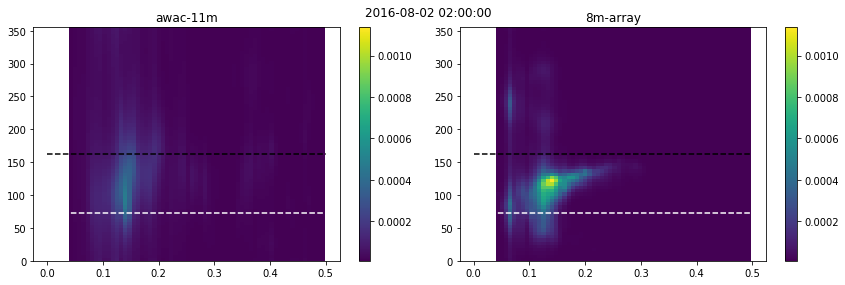

2016-08-18 03:00:00
awac-11m FP H_s: 0.28 [m] D_m 116.82 [deg] ........ 8m-array FP H_s: 0.27 [m] D_m: 101.01 [deg]
awac-11m HP H_s: 0.22 [m] D_m 87.33 [deg] ........ 8m-array HP H_s: 0.24 [m] D_m: 93.17 [deg]
HP diff     H_s: 0.06 [m] D_m 29.49 [deg] ........             H_s: 0.03 [m] D_m: 7.84 [deg]


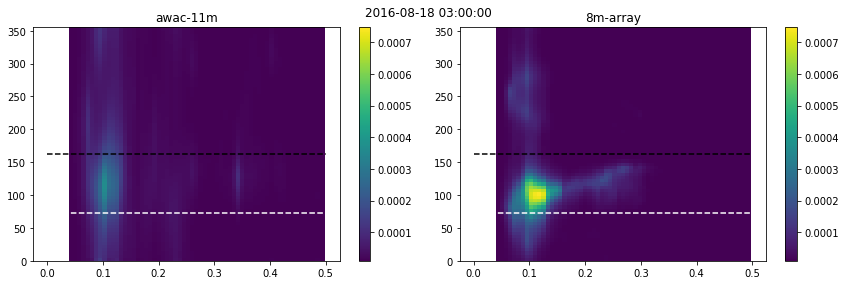

In [174]:
for idxOfInterest in idxHighResidual:
    if np.abs(obs_bulkStat_FP['Hm0'][idxOfInterest] - mod_bulkStat_FP['Hm0'][idxOfInterest]) > 0.05:
        continue
    
    vmin = 0.00001#min(obs_matched['dWED'][idxOfInterest].min(), mod_matched['dWED'][idxOfInterest].min())
    vmax = max(obs_matched['dWED'][idxOfInterest].max(), mod_matched['dWED'][idxOfInterest].max())
    plt.figure(figsize=(12, 4))
    plt.suptitle(obs_matched['time'][idxOfInterest])
    plt.subplot(121)
    plt.pcolormesh(obs_matched['wavefreqbin'], obs_matched['wavedirbin'], obs_matched['dWED'][idxOfInterest].T, vmin=vmin, vmax=vmax)
    plt.title(obslabel)
    plt.plot([0, 0.5], [72, 72], 'w--')
    plt.plot([0, 0.5], [72+90, 72+90], 'k--')
    plt.colorbar()
    plt.subplot(122)
    plt.title(modlabel)
    plt.pcolormesh(mod_matched['wavefreqbin'], mod_matched['wavedirbin'], mod_matched['dWED'][idxOfInterest].T, vmin=vmin, vmax=vmax)
    plt.plot([0, 0.5], [72, 72], 'w--')
    plt.plot([0, 0.5], [72+90, 72+90], 'k--')
    plt.colorbar()
    plt.tight_layout()
    print(obs_matched['time'][idxOfInterest])
    print('{} FP H_s: {:.2f} [m] D_m {:.2f} [deg] ........ {} FP H_s: {:.2f} [m] D_m: {:.2f} [deg]'.format(obslabel, obs_bulkStat_FP['Hm0'][idxOfInterest], obs_bulkStat_FP['Dm'][idxOfInterest], modlabel, mod_bulkStat_FP['Hm0'][idxOfInterest], mod_bulkStat_FP['Dm'][idxOfInterest]))
    print('{} HP H_s: {:.2f} [m] D_m {:.2f} [deg] ........ {} HP H_s: {:.2f} [m] D_m: {:.2f} [deg]'.format(obslabel, obs_bulkStat_HP['Hm0'][idxOfInterest], obs_bulkStat_HP['Dm'][idxOfInterest], modlabel, mod_bulkStat_HP['Hm0'][idxOfInterest], mod_bulkStat_HP['Dm'][idxOfInterest]))
    print('HP diff     H_s: {:.2f} [m] D_m {:.2f} [deg] ........             H_s: {:.2f} [m] D_m: {:.2f} [deg]'.format((obs_bulkStat_FP['Hm0'][idxOfInterest] - obs_bulkStat_HP['Hm0'][idxOfInterest]), (obs_bulkStat_FP['Dm'][idxOfInterest] - obs_bulkStat_HP['Dm'][idxOfInterest]), (mod_bulkStat_FP['Hm0'][idxOfInterest] - mod_bulkStat_HP['Hm0'][idxOfInterest]), (mod_bulkStat_FP['Dm'][idxOfInterest] - mod_bulkStat_HP['Dm'][idxOfInterest])  ))

    plt.show()
